## Introduction/Business Understanding

### Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs? 

For this lab, I used one year of data from the NYPD Stop, Question, and Frisk database. Every time a police officer stops a person in New York City, the officer is required to record the details of the stop. The forms were filled out by hand and manually entered into the NYPD database until 2017, when the forms became electronic. The dataset consists of ~190,000 observations from the annual release in 2013. I chose the year 2013 because it was a turning point in the legality of NYPD being permitted to stop and frisk. Civil rights lawsuits had already been filed alleging racial discrimination, which led to updated practices and a significant drop in police encounters beginning in the year 2014. 2013 is the last year with a large data set; however, it is also representative of New York police aware of scrutiny over their historical policing practices. 

For this classification lab, I am only using ~14,000 records, which reflect the records of people who were actually arrested after being stopped by a police officer. This is a subset of the original 190,000 row data set. The goal is to construct criminal profiles in the city of New York through the use of clustering. The objective is to help NY officers respond to trends in the data of people who were actually arrested and appropriately allocate their resources on potential criminals.
* I acknowledge that this data set only represents a small portion of residents and visitors in New York City who were actually arrested. Any assumptions made from the clustering algorithm would probably include bias since the origin of collecting the data was a response to discrimination.

There is not a single best way to measure the effectiveness of our clustering algorithm. We will look at the reasonableness of the findings in helping the NYPD strategically target people who actually should be arrested. This will help with keeping New York City safe. If I am able to build useful clusters, I will deem the clustering model a success.

## Data Understanding

| Column Name | Description                                                | Data Type |
|-------------|------------------------------------------------------------|-----------|
| pct         | PRECINCT OF STOP (FROM 1 TO 123)                           | Nominal   |
| ser_num     | UF250 SERIAL NUMBER                                        | Nominal   |
| datestop    | DATE OF STOP (MM-DD-YYYY)                                  | Nominal   |
| timestop    | TIME OF STOP (HH:MM)                                       | Scale     |
| recstat     | RECORD STATUS                                              | Nominal   |
| inout       | WAS STOP INSIDE OR OUTSIDE ?                               | Nominal   |
| trhsloc     | WAS LOCATION HOUSING OR TRANSIT AUTHORITY ?                | Nominal   |
| crimsusp    | CRIME SUSPECTED                                            | Scale     |
| typeofid    | STOPPED PERSON'S IDENTIFICATION TYPE                       | Scale     |
| explnstp    | DID OFFICER EXPLAIN REASON FOR STOP ?                      | Nominal   |
| othpers     | WERE OTHER PERSONS STOPPED, QUESTIONED OR FRISKED ?        | Nominal   |
| arstmade    | WAS AN ARREST MADE ?                                       | Nominal   |
| offunif     | WAS OFFICER IN UNIFORM ?                                   | Nominal   |
| frisked     | WAS SUSPECT FRISKED ?                                      | Nominal   |
| searched    | WAS SUSPECT SEARCHED ?                                     | Nominal   |
| ac_proxm    | ADDITIONAL CIRCUMSTANCES - PROXIMITY TO SCENE OF OFFENSE   | Nominal   |
| rf_attir    | REASON FOR FRISK - INAPPROPRIATE ATTIRE FOR SEASON         | Nominal   |
| cs_cloth    | REASON FOR STOP - WEARING CLOTHES COMMONLY USED IN A CRIME | Nominal   |
| ac_incid    | ADDITIONAL CIRCUMSTANCES - AREA HAS HIGH CRIME INCIDENCE   | Nominal   |
| repcmd      | REPORTING OFFICER'S COMMAND (1 TO 999)                     | Nominal   |
| revcmd      | REVIEWING OFFICER'S COMMAND (1 TO 999)                     | Nominal   |
| sex         | SUSPECT'S SEX                                              | Nominal   |
| race        | SUSPECT'S RACE                                             | Nominal   |
| age         | SUSPECT'S AGE                                              | Nominal   |
| ht_feet     | SUSPECT'S HEIGHT (FEET)                                    | Scale     |
| ht_inch     | SUSPECT'S HEIGHT (INCHES)                                  | Nominal   |
| height_in   | SUSPECT'S HEIGHT (INCHES)                                  | Nominal   |
| weight      | SUSPECT'S WEIGHT                                           | Nominal   |
| haircolr    | SUSPECT'S HAIRCOLOR                                        | Scale     |
| eyecolor    | SUSPECT'S EYE COLOR                                        | Nominal   |
| build       | SUSPECT'S BUILD                                            | Nominal   |
| city        | LOCATION OF STOP CITY                                      | Nominal   |
| addrpct     | LOCATION OF STOP ADDRESS PRECINCT                          | Nominal   |

In [2]:
## Import libraries

import pandas as pd
import numpy as np
import urllib
import json
import math 
import category_encoders as ce

%matplotlib inline
from scipy import stats
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from adspy_shared_utilities import plot_labelled_scatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing


# use seaborn plotting defaults
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore')

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#### Import cleaned dataset to use:

In [4]:
## import data
df = pd.read_csv('NYPD.csv', low_memory=False)

## let's take a quick look at our data
df.describe

<bound method NDFrame.describe of         pct  ser_num  datestop  timestop recstat inout trhsloc       crimsusp  \
0         1        2   1012013       452       1     I       T  GRAND LARCENY   
1         1        3   1012013       315       1     I       T  GRAND LARCENY   
2         1        7   1012013       300       1     I       T        ROBBERY   
3         1       11   1012013      1212       A     O       P        ROBBERY   
4         1       12   1012013      2300       A     O       P       BURGLARY   
...     ...      ...       ...       ...     ...   ...     ...            ...   
191846   45     1160  12312013      2320       1     O       H         FELONY   
191847    9     2338  12312013      2337       1     O       P         FELONY   
191848   49     1645  12312013      2350       A     O       P         FELONY   
191849   49     1647  12312013      2350       A     O       P         FELONY   
191850   44     3485  12312013      2350       A     O       P            C

Looks like we have a pretty large dataset (191,851 rows). Let's check to see if there are any NA values and simply drop them from our set since there's a good amount of data present.

In [3]:
df.isna().sum()

pct          0
ser_num      0
datestop     0
timestop     0
recstat      0
inout        0
trhsloc      0
crimsusp     2
typeofid     0
explnstp     0
othpers      0
arstmade     0
offunif      0
frisked      0
searched     0
ac_proxm     0
rf_attir     0
cs_cloth     0
ac_incid     0
repcmd       0
revcmd       0
sex          0
race         0
age          0
ht_feet      0
ht_inch      0
height_in    0
weight       0
haircolr     0
eyecolor     0
build        0
city         0
addrpct      0
dtype: int64

Only a couple of missing values, so we'll handle those by dropping them since we've got a good amount of data

In [4]:
df.dropna

<bound method DataFrame.dropna of         pct  ser_num  datestop  timestop recstat inout trhsloc  \
0         1        2   1012013       452       1     I       T   
1         1        3   1012013       315       1     I       T   
2         1        7   1012013       300       1     I       T   
3         1       11   1012013      1212       A     O       P   
4         1       12   1012013      2300       A     O       P   
5         5        1   1012013       115       1     O       P   
6         5        4   1012013       115       1     O       P   
7         5        5   1012013      1745       1     O       P   
8         6       49   1012013       200       A     O       P   
9         6       50   1012013       405       A     I       P   
10        7        1   1012013        30       A     O       P   
11        7        2   1012013       140       1     O       H   
12        7        3   1012013       140       1     O       H   
13        7        4   1012013       150  

'crimsusp' column could be of value for insights later, but there's a lot of messiness to it!

In [5]:
df['crimsusp'].value_counts().sort_values(ascending=False)

FEL                           36028
FELONY                        32358
MISD                          28386
CPW                           20533
ROBBERY                       13609
BURGLARY                       8016
GLA                            5668
CPM                            3587
GRAND LARCENY                  3470
ASSAULT                        2734
MISDEMEANOR                    2621
CRIMINAL TRESPASS              2278
BURG                           1995
CPCS                           1698
CRIM TRES                      1634
PETIT LARCENY                  1538
CSCS                           1365
FELONY/ROBBERY                 1041
MIS                            1039
ROB                             849
F                               677
M                               638
CRIMINAL MISCHIEF               542
G/L                             533
MIS/CPW                         526
FELONY/BURG                     521
GRAFFITI                        498
MAKING GRAFFITI             

We observe that there are many variations of different crimes that were suspected by the police. We will need to combine some values here to clean this up.

crimsusp appears to be something we can predict off, let's take a deeper look

In [6]:
cs_cts = df['crimsusp'].value_counts().sort_values(ascending=False)
cs_cts = cs_cts[cs_cts > 150]

print(cs_cts)

FEL                   36028
FELONY                32358
MISD                  28386
CPW                   20533
ROBBERY               13609
BURGLARY               8016
GLA                    5668
CPM                    3587
GRAND LARCENY          3470
ASSAULT                2734
MISDEMEANOR            2621
CRIMINAL TRESPASS      2278
BURG                   1995
CPCS                   1698
CRIM TRES              1634
PETIT LARCENY          1538
CSCS                   1365
FELONY/ROBBERY         1041
MIS                    1039
ROB                     849
F                       677
M                       638
CRIMINAL MISCHIEF       542
G/L                     533
MIS/CPW                 526
FELONY/BURG             521
GRAFFITI                498
MAKING GRAFFITI         442
FEL/BURG                418
CPSP                    385
FEL/CPW                 379
CRIM TRESS              343
ASSAULT 3               331
CT                      320
GRAND LARC              308
CRIM TRESPASS       

The good news is that we've accounted for missing values earlier. The bad news is that we have different variations of how "crime suspected" was recorded. This makes sense since different officers may have their preference of entering their personal notes. Let's try to use some intuition in cleaning these columns up.

In [7]:
cs_cts.index.values

array(['FEL', 'FELONY', 'MISD', 'CPW', 'ROBBERY', 'BURGLARY', 'GLA',
       'CPM', 'GRAND LARCENY', 'ASSAULT', 'MISDEMEANOR',
       'CRIMINAL TRESPASS', 'BURG', 'CPCS', 'CRIM TRES', 'PETIT LARCENY',
       'CSCS', 'FELONY/ROBBERY', 'MIS', 'ROB', 'F', 'M',
       'CRIMINAL MISCHIEF', 'G/L', 'MIS/CPW', 'FELONY/BURG', 'GRAFFITI',
       'MAKING GRAFFITI', 'FEL/BURG', 'CPSP', 'FEL/CPW', 'CRIM TRESS',
       'ASSAULT 3', 'CT', 'GRAND LARC', 'CRIM TRESPASS', 'USFM',
       'ROBBERY (FEL)', 'GRAND LARCENY AUTO', 'ROBB', 'BURGLARY (FEL)',
       'CRIM MIS', 'FELONY/GLA', 'FEL/GLA', 'FEL.', 'MIS/ASSAULT',
       'FEL  / CPW', 'AUTO STRIPPING', 'TRESPASS'], dtype=object)

In [8]:
df = df[df['crimsusp'].isin(cs_cts.index.values)]

#### Still seems we can clean the data further

In [9]:
# Replace values remotely close to 'FELONY'
fel_rows = df.loc[df['crimsusp'].isin(['FEL', 'FEL/ASSAULT', 'F', 'FEL.'])].index.values
df.loc[fel_rows, 'crimsusp'] = 'FELONY'

# Replace things that get close to 'BURGLARY'
burg_rows = df.loc[df['crimsusp'].isin(['BURG', 'BURGLARY (FEL)', 'FEL/BURG', 'FELONY/BURG'])].index.values
df.loc[burg_rows, 'crimsusp'] = 'BURGLARY'

# Replace values remotely close to 'MISDEMEANOR'
mis_rows = df.loc[df['crimsusp'].isin(['MIS', 'M', 'MISD'])].index.values
df.loc[mis_rows, 'crimsusp'] = 'MISDEMEANOR'

# Replace values remotely close to 'ROBBERY'
rob_rows = df.loc[df['crimsusp'].isin(['ROB', 'ROBBERY (FEL)', 'ROBB', 'FELONY/ROBBERY'])].index.values
df.loc[rob_rows, 'crimsusp'] = 'ROBBERY'

# Replace values remotely close to 'CRIMINAL TRESPASS'
crim_rows = df.loc[df['crimsusp'].isin(['CRIM TRESS', 'TRESPASS', 'CT', 'CRIM TRESPASS', 'CRIM TRES'])].index.values
df.loc[crim_rows, 'crimsusp'] = 'CRIMINAL TRESPASS'

# Replace values remotely close to 'GRAFFITI'
graf_rows = df.loc[df['crimsusp'].isin(['MAKING GRAFFITI'])].index.values
df.loc[graf_rows, 'crimsusp'] = 'GRAFFITI'

# Replace values remotely close to 'ASSAULT'
as_rows = df.loc[df['crimsusp'].isin(['ASSAULT 3', 'MIS/ASSAULT'])].index.values
df.loc[as_rows, 'crimsusp'] = 'ASSAULT'

# Replace values remotely close to 'ASSAULT'
as_rows = df.loc[df['crimsusp'].isin(['ASSAULT 3'])].index.values
df.loc[as_rows, 'crimsusp'] = 'ASSAULT'

# Replace values remotely close to 'CRIMINAL MISCHIEF'
cm_rows = df.loc[df['crimsusp'].isin(['CRIM MIS'])].index.values
df.loc[cm_rows, 'crimsusp'] = 'CRIMINAL MISCHIEF'

# Replace values remotely close to 'GRAND LARCENY'
gc_rows = df.loc[df['crimsusp'].isin(['GRAND LARC', 'G/L', 'GLA', 'GRAND LARCENY AUTO', 'FEL/GLA', 'FELONY/GLA'])].index.values
df.loc[gc_rows, 'crimsusp'] = 'GRAND LARCENY'

# Replace values remotely close to 'CPW'
cpw_rows = df.loc[df['crimsusp'].isin(['FEL  / CPW', 'FEL/CPW','MIS/CPW'])].index.values
df.loc[cpw_rows, 'crimsusp'] = 'CPW'

In [10]:
df['crimsusp'].value_counts().sort_index()

ASSAULT               3227
AUTO STRIPPING         157
BURGLARY             11158
CPCS                  1698
CPM                   3587
CPSP                   385
CPW                  21597
CRIMINAL MISCHIEF      747
CRIMINAL TRESPASS     5011
CSCS                  1365
FELONY               69240
GRAFFITI               940
GRAND LARCENY        10576
MISDEMEANOR          32684
PETIT LARCENY         1538
ROBBERY              15934
USFM                   279
Name: crimsusp, dtype: int64

#### Fantastic! It looks like we got down to 17 values for the crimsusp column, as opposed to the initial 2615!

In [11]:
# Saving to a .csv in case!
df.to_csv('nypd_cleaned.csv', sep = ",")

In [12]:
# import data
df = pd.read_csv('nypd_cleaned.csv', low_memory=False)

#### We will be running a clustering analysis on those who were arrested. So we will reduce our dataframe down to only columns containing an arrested suspect (from 190,000 rows to 14,000).

In [13]:
## Get rowIndex for which column [arstmade=0]. We only care about those who WERE arrested.
rowIndex = df[df['arstmade'] == 'N'].index

## Drop these rows from our dataframe, as they are no longer a part of our analysis
df.drop(rowIndex , inplace=True)

In [14]:
## Double-check that we've dropped them, and they have. We're now down to ~14k rows of arrested suspects to analyze
df.describe

<bound method NDFrame.describe of         Unnamed: 0  pct  ser_num  datestop  timestop recstat inout trhsloc  \
7                7    5        5   1012013      1745       1     O       P   
17              17    9        3   1012013       815       A     I       P   
23              24   10        1   1012013       935       1     I       H   
27              28   13        1   1012013      1503       1     O       P   
39              43   19        3   1012013       500       1     I       P   
59              64   23       31   1012013       630       1     I       H   
107            115   30       13   1012013       436       A     O       P   
111            120   30       41   1012013       100       1     I       H   
112            121   30       44   1012013       215       A     O       P   
126            137   32       16   1012013       415       A     I       P   
128            139   32       69   1012013       520       A     O       P   
134            145   33       

#### With nearly 14,000 rows available to analyze, we're going to assume there are no duplications or outlier data points in our set. If there are, they should not affect our analysis too much given the volume of data.

### Visualize any important attributes appropriately

For this clustering problem, I decided to inlude only the people in our data set who were ultimately arrested, which represents about 7% of our original data set. Some important factors to prediction include the following: the city the crime took place in, the crime the person was suspected of, whether the crime took place inside or outside, whether or not the person was wearing seasonally appropriate clothing, and the sex of the person. Our visualizations for these factors are below.

### Cities where our stopped suspects were arrested

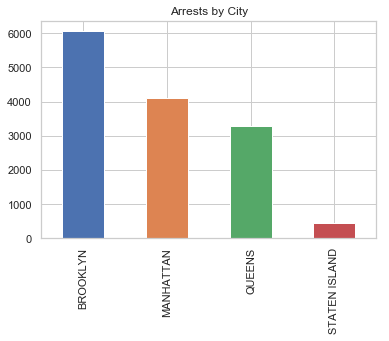

In [51]:
df['city'].value_counts().plot(kind='bar', title='Arrests by City');


#### Looks like we can clean this up a little further by combining the two notations for Staten Island.

In [16]:
### Looks like we can clean this up a little further..

# Replace values remotely close to 'BROOKLYN'
bkn_rows = df.loc[df['city'].isin(['BRONX'])].index.values
df.loc[bkn_rows, 'city'] = 'BROOKLYN'

# Combine Staten Island values
si_rows = df.loc[df['city'].isin(['STATEN IS'])].index.values
df.loc[si_rows, 'city'] = 'STATEN ISLAND'

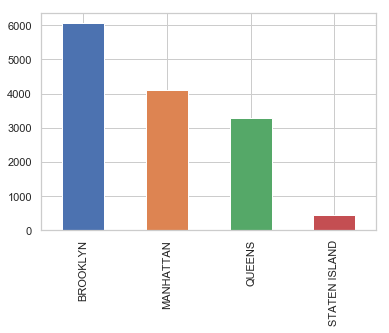

In [17]:
df['city'].value_counts().plot(kind='bar', title='Arrests by City');

#### It appears that close to half of the suspects were arrested in the Brooklyn area, with Manhattan and Queens each representing about a quarter of arrests made. Staten Island appears to have very few arrests - either it is a relatively safer area or there are crimes being committed with no arrests made.

### Which crime was suspected, as the reason for the stop, which led to an arrest?

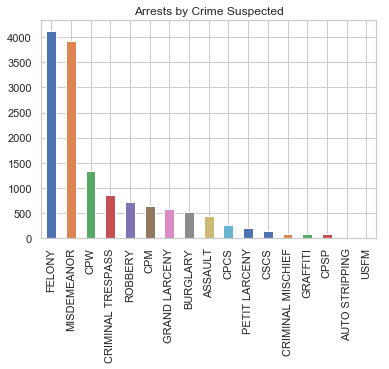

In [52]:
df['crimsusp'].value_counts().plot(kind='bar', title='Arrests by Crime Suspected');

#### When the crime suspected was either a felony or misdemeanor, it often led to an arrest. It also seems like there may be differences in how police officers record the crime suspected category because some of the less frequently occurring crimes seem like they could also be classified as a felony or misdemeanor. Despite the possible errors in data collection, for now we will still leave this in our clustering algorithm because it seems beneficial to see if there are differences in where felonies and misdemeanors occur and who is committing these crimes. This knowledge could be helpful to the NYPD in making staff decisions.

### Was the suspect stopped inside or outside?

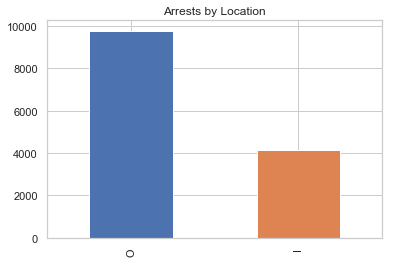

In [53]:
df['inout'].value_counts().plot(kind='bar', title = 'Arrests by Location');

#### It appears the number of people arrested outside was more than double the number who were arrested while inside.

### Was the suspect wearing attire, not appropriate for the current season?

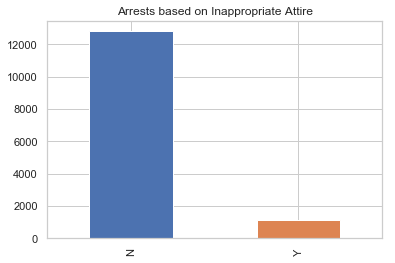

In [55]:
df['rf_attir'].value_counts().plot(kind='bar', title = 'Arrests based on Inappropriate Attire');

#### It seems the New York criminals dressed their part when committing a crime. As you can see, they overwhelmingly dressed seasonly-appropriate when arrested. This might be more evenly distributed between who was frisked and not frisked in our original data set, as inappropriate clothing for the weather was a reason given for police officers to frisk a suspect. However, this variable did appear in our arrested vs. not arrested model and it would be interesting to see if our clusters unearth any more information about its importance.

### Does gender play a role in whether or not a suspect was arrested?

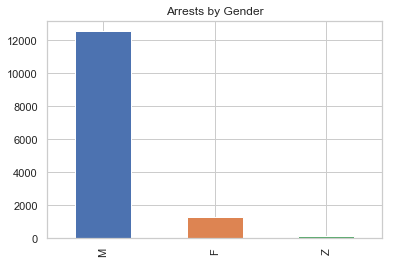

In [56]:
df['sex'].value_counts().plot(kind='bar', title='Arrests by Gender');

#### Men are arrested overwhelmingly more often than women. However, we will leave it in our model to see if any more subtle patterns occur through clustering.

## Modeling and Evaluation (50 points total)

#### Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. Each option is broken down by:

**Option A: Cluster Analysis**
- Train: Perform cluster analysis using several clustering methods (adjust parameters).
- Eval: Use internal and/or external validation measures to describe and compare the
clusterings and the clusters— how did you determine a suitable number of clusters for
each method?
- Visualize: Use tables/visualization to discuss the found results. Explain each
visualization in detail.
- Summarize: Describe your results. What findings are the most interesting and why?

#### Our original dataset had over 100 features, and we have utilized them in slightly different ways for each lab. This time we wanted to see if we could build meaningful clusters using only the features which were significant to building our prediction models from the second Data Mining Lab. Since we are using only a handful of features, we used label encoder to change our many categorical features into numbers. This helps the clustering algorithms use these features in meaningful ways.

#### Originally we had used onehot encoder. This is usually preferable practice - but for this data set and purpose, keeping the number of features compact was preferable to allow for us to disect the clustering outcomes. As such, we proceded with lable encoder instead. This new dataframe is df2. 

In [22]:
le = preprocessing.LabelEncoder()
df2 = df.apply(le.fit_transform)

In [23]:
#just a quick overview of the features in our tranformed dataframe for reference.

for col in df2.columns: 
    print(col) 

Unnamed: 0
pct
ser_num
datestop
timestop
recstat
inout
trhsloc
crimsusp
typeofid
explnstp
othpers
arstmade
offunif
frisked
searched
ac_proxm
rf_attir
cs_cloth
ac_incid
repcmd
revcmd
sex
race
age
ht_feet
ht_inch
height_in
weight
haircolr
eyecolor
build
city
addrpct


#### Next, we subset our data frame to the nine predictive features, which showed the most significance in our logistic regression prediction models. We also convert the data frame into an array, so that it is compatible with the scikit-learn package, which we will need for clustering.

In [24]:
#Now that we have our original df, our encoded dataframe - df2 - we want to subset further base on our previous research.
#We have subset the original df to the 9 most important variables and stored it in a new dataframe - data. 
#We've also converted our dataframe into an array so that it can be fed into scikit-learn. 

data = df2[['city','crimsusp', 'inout', 'rf_attir', 'sex', 'age', 'race', 'build', 'height_in']]
data_y_empty = (df2[['arstmade']]-1)['arstmade'] 
data_y = (df2[['arstmade']])
X = np.array(data).astype(float)
y = np.array(data_y).astype(float)
y_empty = np.array(data_y_empty).astype(float)

### Train and adjust parameters & Evaluate Using Internal or External Validation Measures

#### Evaluate: First, we will use the elbow method to help us decide how many clusters to use in our model. The elbow model uses Within-Cluster Sum of Squares (WCCS) to measure the ideal amount of clusters to use in your model. Our elbow model shows us that two clusters are ideal, but that three or four might also work. It appears that five or more would be too many clusters to be meaningful. It is possible that having so few clusters might hurt the end goal of building criminal profiles, but we will keep investigating.

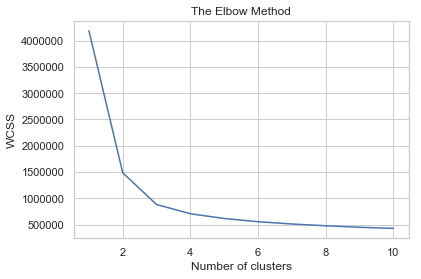

In [25]:
#Lets take a quick look at how our subsetted and transformed dataset clusters using the Within-Clusters-Sum-of-Squares.
#Using the 'elbow method' we can quickly see that anything over 3 clusters is going to yeild limited benefits.

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### We used K-means clusters to build three clusters. K-means clustering works by separating the data points into number of clusters where each data point belongs to the cluster with the nearest mean. K-means clustering also shares similarities with the K-nearest neighbors algorithm. While our elbow plot suggested two clusters would be better. It seemed like for our business purpose it would make more sense to stick with three to see if we could find any significant differences between the arrested people in each group without losing too much integrity in our clustering model. We will procede in building models with three clusters.

In [26]:
#Now lets dive right into clustering of our 9 features with 3 clusters. 
#As it is best practice, we will be standardzing the columns.
#We will then glue the cluster name back to the dataframe so we can run some basic statistics to see what its clustering on. 

#In this case roughly see where we have the clusters breaking apart.
#Note - since at this time features are encoded, it doesnt make a whole lot of sense, 
#but we will tie it back to the un-encoded data frame later

#Cluster 1 - The combination of in/outside, sex, and height seem to be pulling this one out.
#Cluster 3 - This cluster is mostly those on the other end of the spectrum. for inside/outside, sex seems much more mixed, 
#they are much shorter as well, and arrest location seems to be playing a bigger role. 
#Cluster 2 - Seems to be the awkward middle ground - however rf_attir seems to really be setting it apart from other features. 

#Make a copy of DF
df_tr = data

#Standardize
clmns = ['city','crimsusp', 'inout', 'rf_attir', 'sex', 'age', 'race', 'build', 'height_in']
df_tr_std = stats.zscore(df_tr[clmns])

#Cluster the data
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_tr_std)
labels = kmeans.labels_

#Glue back to original data
df_tr['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

#Lets analyze the clusters
print(df_tr[clmns].groupby(['clusters']).mean())

              city  crimsusp     inout  rf_attir       sex        age  \
clusters                                                                
0         0.939871  9.649412  0.996606       0.0  1.011153  29.541641   
1         0.974176  9.592164  0.796082       1.0  0.950134  29.382012   
2         0.703907  9.755048  0.144864       0.0  0.738367  31.756365   

              race     build  height_in  
clusters                                 
0         2.570493  1.267669  20.034550  
1         2.526269  1.268923  19.912734  
2         2.475856  1.286655  18.892011  


#### Our first clustering model is pictured below. It's not especially indicative of a good model, but we knew that might happen due to the majority of our features being categorical. When features in a clustering model are categorical and not continuous, they cluster by definition which detracts from the overall model.

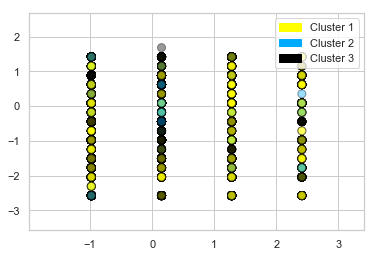

In [27]:
#Lets take a quick look at how this plots.
#As expected with so many categorical variables, we really dont get the visual that we can digest well. 

plot_labelled_scatter(df_tr_std, kmeans.labels_,
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])

#### The chart below shows the breakdown of our clusters. With over 8,000 records, our first cluster consists of just 59% of our arrested NYPD data set. Our second cluster is only about 8% of our data set and our third cluster is about 33% of the data. This spread of our data is decent and we will proceed and build the next iteration of our clustering model.

In [28]:
df_tr.groupby(['clusters']).count()

,city,crimsusp,inout,rf_attir,sex,age,race,build,height_in
clusters,,,,,,,,,
0,8249,8249,8249,8249,8249,8249,8249,8249,8249
1,1123,1123,1123,1123,1123,1123,1123,1123,1123
2,4556,4556,4556,4556,4556,4556,4556,4556,4556


#### In our next clustering attempt, we decided to cut the factors even more. We removed crime suspected, sex, and race from our data frame to see if it provided a better clustering model. The clusters were much stronger and we saw significantly more separation between features in our second clustering model, especially the city feature. Whether the person arrested was inside or outside also seemed to heavily influence this clustering model. We gathered this information from our table. As our data is still heavily categorical, the clustering visual was not all that helpful in choosing which model to use. While our clusters were stronger in this model, a use-case with this data is to possibly build criminal profiles. We see benefit to having more features included in the model to round out our profiles a little bit better and so we will procede by analyzing our first clustering model.

In [29]:
#Since a lot of the variables were really driving similarity within clusters, we decided to drop crimsusp, sex, and race,
#the features with the least seperation across groups, to see if we could drive a bit more insight.

#Now we're seeing a lot more seperation among features. City is really standing out in cluster 1.
#in/outside seems to be driving clusters 1 and 3, but mixed in 2. Age seems to be a factor in cluster 1. 
#Build and height seem to have standardized a bit after removing the other features. 


#Make a copy of DF
df_tr = data

#Standardize
clmns = ['city', 'inout', 'rf_attir', 'age', 'build', 'height_in']
df_tr_std = stats.zscore(df_tr[clmns])

#Cluster the data
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_tr_std)
labels = kmeans.labels_

#Glue back to original data
df_tr['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

#Lets analyze the clusters
print(df_tr[clmns].groupby(['clusters']).mean())

              city     inout  rf_attir        age     build  height_in
clusters                                                              
0         0.672018  0.000000       0.0  32.019878  1.285168  19.357798
1         0.937169  1.000000       0.0  29.582817  1.269677  19.747438
2         0.974176  0.796082       1.0  29.382012  1.268923  19.912734


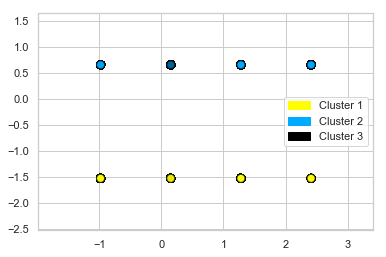

In [30]:
#Again - like above - not really a visual we can interpret much from.

plot_labelled_scatter(df_tr_std, kmeans.labels_,
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])

In [31]:
#Moving forward with the second k means we did, lets attach it back to our original df so we can better understand the clusters. 

df['clusters'] = labels
df.head()

,Unnamed: 0,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,crimsusp,typeofid,...,ht_feet,ht_inch,height_in,weight,haircolr,eyecolor,build,city,addrpct,clusters
7,7,5,5,1012013,1745,1,O,P,BURGLARY,V,...,5,5,65,165,BK,BR,M,MANHATTAN,5,1
17,17,9,3,1012013,815,A,I,P,FELONY,P,...,5,10,70,130,BL,BL,T,MANHATTAN,9,0
23,24,10,1,1012013,935,1,I,H,CRIMINAL TRESPASS,V,...,5,9,69,160,SP,BR,M,MANHATTAN,10,0
27,28,13,1,1012013,1503,1,O,P,MISDEMEANOR,P,...,5,10,70,165,BR,BR,T,MANHATTAN,13,1
39,43,19,3,1012013,500,1,I,P,MISDEMEANOR,P,...,5,4,64,145,RA,BR,M,MANHATTAN,19,0


### Visualize Results

#### First, we tried to compare categorical variables with continuous variables by cluster as can be seen in the two plots below. However, we were not able to gain much insight from these plots and found more useful information for defining our clusters in stacked bar charts, as can be seen further down in this section.

Text(0.5,1,'Crime Suspected vs. Height')

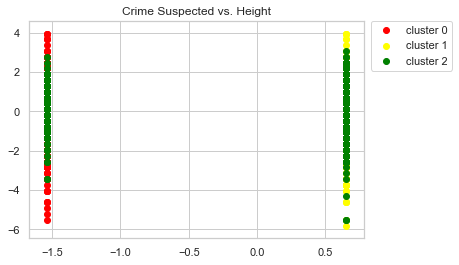

In [32]:
plt.scatter(df_tr_std[labels==0,1],df_tr_std[labels==0,5],c='red',label='cluster 0')
plt.scatter(df_tr_std[labels==1,1],df_tr_std[labels==1,5],c='yellow',label='cluster 1')
plt.scatter(df_tr_std[labels==2,1],df_tr_std[labels==2,5],c='green',label='cluster 2')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.title('Crime Suspected vs. Height')

In [33]:
df_tr_std

array([[ 0.15194171,  0.65181235, -0.29614206,  0.89782803, -0.39999828,
        -1.08020391],
       [ 0.15194171, -1.53418389, -0.29614206, -0.92866296,  1.05995351,
         0.3991259 ],
       [ 0.15194171, -1.53418389, -0.29614206,  1.08047713, -0.39999828,
         0.10325994],
       ...,
       [ 0.15194171,  0.65181235,  3.37675781,  0.6542959 , -0.39999828,
        -0.78433795],
       [-0.97732409,  0.65181235, -0.29614206, -0.01541747, -0.39999828,
         0.10325994],
       [-0.97732409,  0.65181235, -0.29614206, -0.13718353, -0.39999828,
         0.3991259 ]])

Text(0.5,1,'Crime Suspected vs. Age')

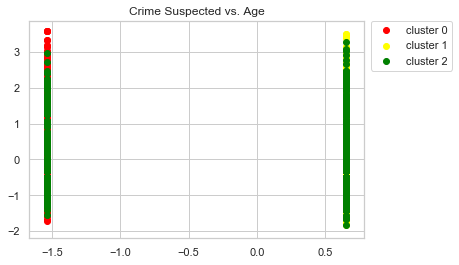

In [34]:
plt.scatter(df_tr_std[labels==0,1],df_tr_std[labels==0,3],c='red',label='cluster 0')
plt.scatter(df_tr_std[labels==1,1],df_tr_std[labels==1,3],c='yellow',label='cluster 1')
plt.scatter(df_tr_std[labels==2,1],df_tr_std[labels==2,3],c='green',label='cluster 2')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.title('Crime Suspected vs. Age')

#### Our first stacked bar chart below breaks down how men and women were distributed betwen our three clusters. There was also a third category, unknown, which made up a very small fraction of the overall data. 95% of the women who were arrested were put in cluster three. Also, notable is that 95% of the people with an unknown sex were placed into the first cluster. This confirms our earlier suspicions that sex is a strong segmenter within our clusters. If given more time it would be interesting to delve further to see if there is another influential feature that is related to sex or if a person's sex is a stand-alone influential feature.

Text(0.5,1,'Count by Cluster and Gender')

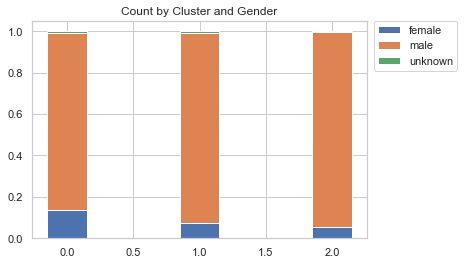

In [35]:
sex_count = df_tr.groupby(['clusters','sex']).count().age
sex_c = sex_count.values.reshape((3,3))
sex_c = sex_c/sex_c.sum(axis=1)[:,None]


idx = (0,1,2)
plt.bar(idx,sex_c[:,0],0.3,label='female')
plt.bar(idx,sex_c[:,1],0.3,bottom=sex_c[:,0],label='male')
plt.bar(idx,sex_c[:,2],0.3,bottom=sex_c[:,1]+sex_c[:,0],label='unknown')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.title('Count by Cluster and Gender')

In [36]:
sex_c = sex_c*100
sex_c

array([[13.58307849, 85.70336391,  0.71355759],
       [ 7.44285553, 91.81398491,  0.74315955],
       [ 5.4318789 , 94.12288513,  0.44523598]])

#### This stacked bar chart explores how the different boroughs within New York City were clustered. Very few people overall were arrested in Staten Island; however, if that is where they were arrested they were more likely to be assigned to the first cluster. Brooklyn had the most arrests, but Brooklyn arrests seem to be pretty proportionally spread between our three clusters. Another interesting trend is Queens is overrepresented in cluster one over cluster three (31% to 11%). While Manhattan seems to be overrepresented in cluster three over cluster one (44% to 25%).

Text(0.5,1,'Count by Cluster and City')

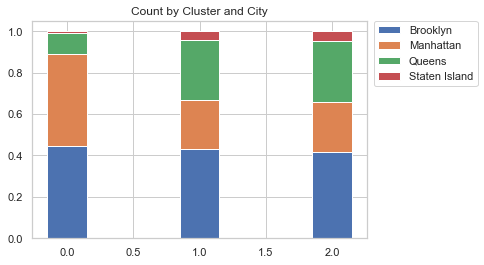

In [37]:
city_count = df_tr.groupby(['clusters','city']).count().age

city_c = city_count.values.reshape((3,4))
city_c = city_c/city_c.sum(axis=1)[:,None]


plt.bar(idx,city_c[:,0],0.3,label='Brooklyn')
plt.bar(idx,city_c[:,1],0.3,bottom=city_c[:,0],label='Manhattan')
plt.bar(idx,city_c[:,2],0.3,bottom=city_c[:,1]+city_c[:,0],label='Queens')
plt.bar(idx,city_c[:,3],0.3,bottom=city_c[:,1]+city_c[:,0]+city_c[:,2],label='Staten Island')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.title('Count by Cluster and City')

In [38]:
city_c = city_c*100
city_c

array([[44.72477064, 44.36799185,  9.88786952,  1.01936799],
       [43.328454  , 23.6685058 , 28.96070262,  4.04233757],
       [41.67408727, 24.04274265, 29.47462155,  4.80854853]])

#### The following stacked bar plot allows you to see the build breakdown by cluster. As you can see visually, build does not give us that much information in defining our clusters. We have somewhat even distribution of builds relative to the overal cluster size.

Text(0.5,1,'Count by Cluster and Build')

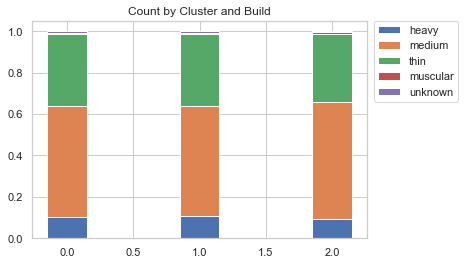

In [39]:
build_count = df_tr.groupby(['clusters','build']).count().age
build_c = build_count.values.reshape((3,5))
build_c = build_c/build_c.sum(axis=1)[:,None]


plt.bar(idx,build_c[:,0],0.3,label='heavy')
plt.bar(idx,build_c[:,1],0.3,bottom=build_c[:,0],label='medium')
plt.bar(idx,build_c[:,2],0.3,bottom=build_c[:,1]+build_c[:,0],label='thin')
plt.bar(idx,build_c[:,3],0.3,bottom=build_c[:,2]+build_c[:,1]+build_c[:,0],label='muscular')
plt.bar(idx,build_c[:,4],0.3,bottom=build_c[:,3]+build_c[:,2]+build_c[:,1]+build_c[:,0],label='unknown')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.title('Count by Cluster and Build')

In [40]:
build_c = build_c*100
build_c

array([[10.14271152, 53.64424057, 34.63302752,  0.71355759,  0.86646279],
       [11.0010134 , 53.06834816, 34.60195924,  0.61929963,  0.70937957],
       [ 9.34995548, 56.36687444, 32.85841496,  0.89047195,  0.53428317]])

#### The following stacked bar plot allows you to see the race breakdown by cluster. It is important to note that we did not include the races which were so infreqeuntly cataloged that they would not be noticeable on our plot. This plot does not seem to give us any useful information in defining our clusters as it appears that the races are proportionally distributed between our three clusters.

Text(0.5,1,'Count by Cluster and Race')

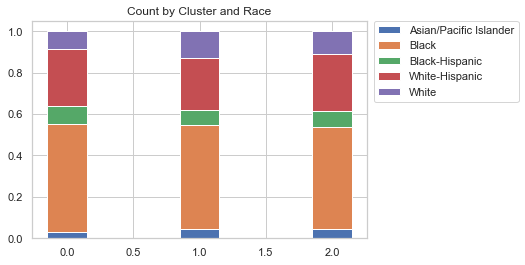

In [41]:
#delete races that are significantly under represented in the data set
df_tr.race.value_counts()
df_tr_dropped = df_tr[(df_tr.race != 2) & (df_tr.race != 5)& (df_tr.race != 7)]
df_tr_dropped.race.value_counts()

#group by race and clusters
race_count = df_tr_dropped.groupby(['clusters','race']).count().age
race_count

race_c = race_count.values.reshape((3,-1))
race_c = race_c/race_c.sum(axis=1)[:,None]

#plot stacked bar chart
plt.bar(idx,race_c[:,0],0.3,label='Asian/Pacific Islander')
plt.bar(idx,race_c[:,1],0.3,bottom=race_c[:,0],label='Black')
plt.bar(idx,race_c[:,2],0.3,bottom=race_c[:,1]+race_c[:,0],label='Black-Hispanic')
plt.bar(idx,race_c[:,3],0.3,bottom=race_c[:,1]+race_c[:,0]+race_c[:,2],label='White-Hispanic')
plt.bar(idx,race_c[:,4],0.3,bottom=race_c[:,1]+race_c[:,0]+race_c[:,2] +race_c[:,3],label='White')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.title('Count by Cluster and Race')

In [42]:
race_c = race_c*100
race_c

array([[ 3.18371608, 52.13987474,  8.79436326, 27.53131524,  8.35073069],
       [ 4.49115552, 50.11486331,  7.11003905, 25.51114174, 12.77280037],
       [ 4.34782609, 49.63768116,  7.33695652, 27.44565217, 11.23188406]])

### Summarize Ramifications

#### The names of our clusters below are meant to be silly. While we achieved moderate success in identifying the determining factors to how people were distributed between clusters, we also are aware that our findings are not especially useful in our chosen business case as defined earlier. We will further critique our work in the subsequent deployment section. However, for now,  the profiles of our NYPD arrested people data are outlined below.

#### Cluster 1 (0 on plots):
##### Cluster 1 had the most records represented with 59% of the data.  The first breakdown of clusters was the mean of the different factors. While it did not tell us all that much because most of our variables are categorical, it did reveal that the mean age of our first cluster is similar to our second cluster at 29 years old. Queens seems to be the dominant borough in cluster one. Brooklyn is also heavily represented though that is more representative of Brooklyn being home to a significantly large portion of New York City's arrests. Also notable, while Staten Island has very few arrests over all, the arrests they did have mostly show up in our first cluster. Our first cluster was predominately made up of men, with less just slightly over one percent categorized as female or unknown. Build and race seem to be proportionally distributed between the three clusters and within each cluster. It does not seem like build or race had much weight on which cluster an arrested person was assigned to.

#### Cluster 2 (1 on plots):
##### Cluster 2 was our smallest cluster by far with only 8% of the data. The city breakdown within our second cluster appears to be a pretty even split between Brooklyn, Manhattan, and Queens. This is not proportional to our data overall and so it seems like city was not especially influential in assigning a record to the second cluster. The first breakdown of clusters was the mean of the different factors. While it did not tell us all that much because most of our variables are categorical, it did reveal that the mean age of our second cluster is similar to our first cluster at 29 years old. The second cluster also seemed Our second cluster was also predominately male. Again, build and race seem to be proportionally distributed between the three clusters and within each cluster. It does not seem like these factors had much weight on which cluster an arrested person was assigned to.

#### Cluster 3 (2 on plots): "Orange is the New Black" Cluster
##### Cluster 3 contained the remaining 33% of the data. The first breakdown of clusters was the mean of the different factors. While it did not tell us all that much because most of our variables are categorical, it did reveal that the mean age of our third cluster, at almost 32 years old, was about three years older than clusters one and two which had a mean age of 29 years old. Manhattan seems to be the dominant borough in cluster one. Brooklyn is also heavily represented though that is more representative of Brooklyn being home to a significantly large portion of New York City's arrests. Another interesting thing was our arrested females were overwhelmingly assigned to the third cluster. We assume it is because they are female, but it is possible it is because of another attribute we did not discover in our analysis. We are not going to make assumptions, but it would be interesting to delve further and see if the women arrested by NYPD are typically older than the men arrested and if that is what drove up the mean age in cluster three. Build and race seem to be proportionally distributed between the three clusters and within each cluster. It does not seem like these factrors had much weight on which cluster an arrested person was assigned to.

### Principal Component Analysis (PCA)

#### The following section uses a dimensionality reduction technique known as PCA (principle component analysis) to summarize features in our data. The idea for using PCA prior to cluster analysis is that the principle components may 'extract' the structure of our clusers in the dataset. Once normalized, the first few PC's which contain most of the variations in the data are going to be used in the cluster analysis.

In [43]:
#Just going to drop the glued clusters from above.

del data['clusters']

In [44]:
#Our dataset isn't great for clustering, but by using PCA we can drive a bit more insight. 

#Start by normalizing and creating to principal components. 
#Our shape is down from 9 features to 2.

X_normalized = StandardScaler().fit(X).transform(X)  
pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)
print(X.shape, X_pca.shape)

(13928, 9) (13928, 2)


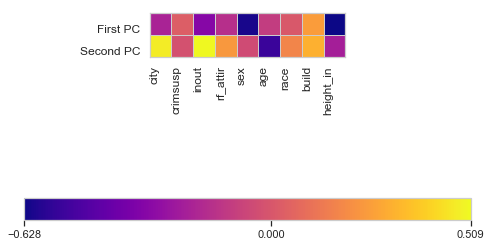

In [45]:
#Now that we have 2 principal components, lets see how each feature plays into the PC.
#Each feature and the weighting in the PC can be seen below, its a bit of an eyeball process here.
#As we can see some things that made it hard to cluster above are represented here (race, build, etc..)

fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(data.columns)

plt.gca().set_xticks(np.arange(-.5, len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                                pca.components_.max()], pad=0.65);

#### As an interpretation of the graph above, the features that exhibit opposite colors of the bar spectrum are considred important in the analysis. Race is an example of an arbitrary feature where it may not have much of an impact in the cluster analysis. City, arrested inside/outside, and age seem to be the features that matter most in this graphical representation. 

#### Now that we have principal components instead of discrete features, lets plot it.

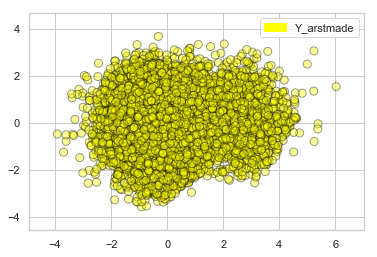

In [46]:
plot_labelled_scatter(X_pca, data_y_empty, ['Y_arstmade'])

#### We can now use kmeans to apply 2 clusters to our dataset. Since we are only using 2 principal components, we expected kmeans would largely just draw boundaries along each of those groups. Looking at our visiual this seems to be the case. Again, our data is suboptimal for clustering, and as such, we are seeing a lot of overlap. It is clear, however, that as we move up or down the X axis that there is some seperation at the poles. 

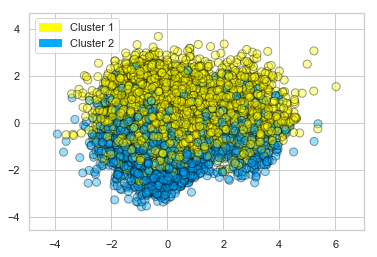

In [47]:
X_normalized = MinMaxScaler().fit(X_pca).transform(X_pca)  

kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans.fit(X)

plot_labelled_scatter(X_pca, kmeans.labels_,
                      ['Cluster 1', 'Cluster 2'])

#### Having applied 2 clusters, we were curious if 3 clusters, as used above would result in a clearer output. As we can see from the visual, many of the data points in the middle ground now fall into the thrid cluster. Comparing this to our exploration of the non-pca transformed data above, we are seeing many similarities in the way these three clusters have been constructed. 

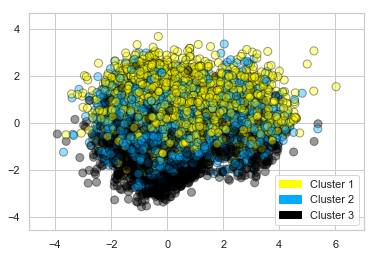

In [48]:
#Now lets apply 3 clusters to this data. 
#Not surprisingly, the clusters kind of fall along the lines of what we observed above. 

X_normalized = MinMaxScaler().fit(X_pca).transform(X_pca)  

kmeans = KMeans(n_clusters = 3, random_state = 0)
kmeans.fit(X)

plot_labelled_scatter(X_pca, kmeans.labels_,
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])

In [49]:
#Plotting metrics for future reference if needed. 

print(X_pca)

[[ 0.07699941  0.13203986]
 [ 0.44754713  0.26279093]
 [ 0.03658873 -1.64216887]
 ...
 [-0.57420518  0.93455415]
 [-0.30482787 -0.58708348]
 [-0.47891087 -0.58705012]]


### DBSCAN Implementation

#### We were also curious to se if we could apply a density based clustering to the above PCA transformed points. As DBSCAN is by far the most popular and well documented, we proceded with that.

#### Our initial thought was that since there was so little seperation in the points (as can be seen from the plotted PCA points above) that a density based apporach would be pointless. And our assumptions turned out to be true. The amount of 'noise' present as represented by the blue prevents distinct clusters to form.

#### Here we start at a distance (eps) of 0.1 and a minimum of 2 samples. There is some sepraton around the edges but otherwise it is obsucred by noise. 

#### We then decrease to an eps of 0.01 and can see some addtional seperation in the middle noise, again, not enough to be useful.

#### Surprisingly, at an eps of 0.001, we actually see performance worsen. The same holds true for the number of samples. Anything above 2 and noise overtakes the visual.

#### If we had a more sparse dataset, it may be apporpriate to use, or if we used some form of sampling, but as it stands that is not the case.


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


dbscan = DBSCAN(eps=0.01, min_samples = 2)
clusters = dbscan.fit_predict(X_pca)
labels = dbscan.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="plasma")

### Deployment / Recap 

#### Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?

The goal was to use clustering algorithms to help the NYPD better, strategically deploy their patrol officers in a way that would help them arrest actual culprits and not waste time on innocent citizens. We did not accomplish our goal. We were able to build basic profiles of people arrested in New York City in the year 2013; however, they are not meaningful in a way that would actually help patrol officers. It's possible that we could have built clearer profiles with more features included, though we know clustering algorithms can struggle as more information is added into the mix. 

#### How would your deploy your model for interested parties?
I would not deploy our model for interested parties. This data already lends itself to bias because of how police officers are known to interact differently with different groups of people and in different places. Until I have a very good clustering model, it would not be appropriate to deploy because it is possible a poor model would have a very real and detrimental impact on a people's lives.

#### What other data should be collected? How often would the model need to be updated, etc.? 
The NYPD releases their stop and frisk data quarterly, with a more complete report released at the end of every year. It would be interesting to add additional data to our model to see if it might change meaningfulness of our results. It would also be interesting to complete clustering analyses on different quarters and compare the results. This might provide insight to trends in data of who is arrested and if given several years might reveal seasonality in the data as well. I recommend revisiting the model quarterly as data is released to continue tracking how the people being arrested cluster into different groups. Having police officers collect more continuous factors should help improve the model, though it would hard to make a business argument for arbitrary data collection. Lastly, it would be interesting to bring in data on policing measures. If we were to include data such as police on patrol or maybe type of officer, that might add insight into other metrics for whether or not the police are making progress in their policing goals.